In [76]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 
import matplotlib

# Data visu 

In [77]:
#data importation 
data = pd.read_csv("datas/simulated_4K_cloud_gaming_dataset.csv")

print("dataframe information gathering ")

print (data.head())
print (data.index)
print (data.columns)
print (data.dtypes)
print (data.info())
print (data.describe())




dataframe information gathering 
   CPU_usage  GPU_usage  Bandwidth_MBps  Latency_ms  FrameRate_fps  Jitter_ms  \
0         71         65       19.770323   66.202388      59.107060  13.085300   
1         34         40        8.092595   32.207380      57.969683   8.567330   
2         91         55       16.841666  133.478904      52.248079   1.129479   
3         80         73       15.702267  125.328933      38.382477  10.944737   
4         40         76       11.227322  111.041017      33.949608  18.508754   

   QoE_score  
0          3  
1          3  
2          1  
3          1  
4          2  
RangeIndex(start=0, stop=1000, step=1)
Index(['CPU_usage', 'GPU_usage', 'Bandwidth_MBps', 'Latency_ms',
       'FrameRate_fps', 'Jitter_ms', 'QoE_score'],
      dtype='object')
CPU_usage           int64
GPU_usage           int64
Bandwidth_MBps    float64
Latency_ms        float64
FrameRate_fps     float64
Jitter_ms         float64
QoE_score           int64
dtype: object
<class 'pandas.co

# Data Cleaning 

In [78]:
print (data.shape)

(1000, 7)


In [79]:
data = data.dropna()
data = data.drop_duplicates()

In [80]:
print (data.shape)

(1000, 7)


# Visualisation

In [81]:
print(data['QoE_score'].value_counts())

QoE_score
3    379
2    312
1    222
4     84
5      3
Name: count, dtype: int64


## Déséquilibre des classes (ou des notes de QoE à gérer)

<Figure size 1000x600 with 0 Axes>

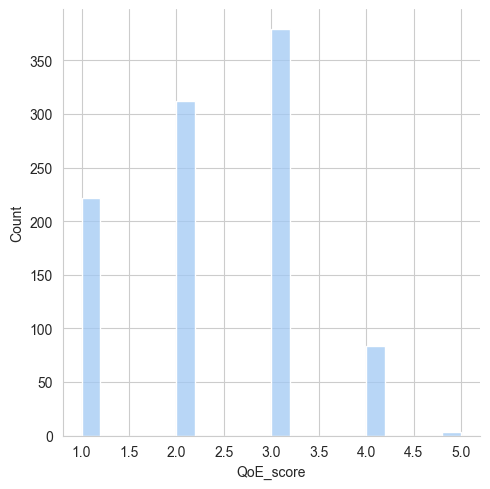

In [82]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.displot(data['QoE_score'])
plt.show()

### View of key features 

<Axes: xlabel='QoE_score', ylabel='Latency_ms'>

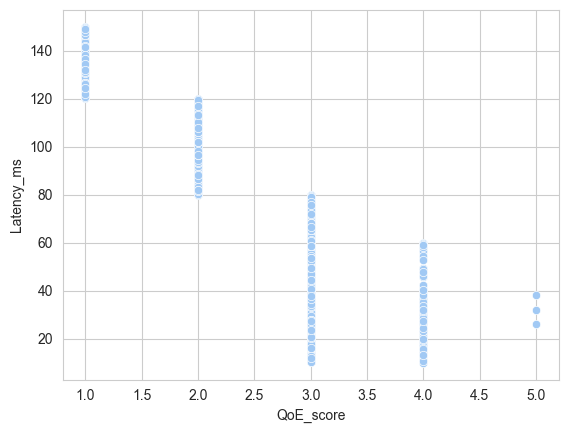

In [83]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'Latency_ms')

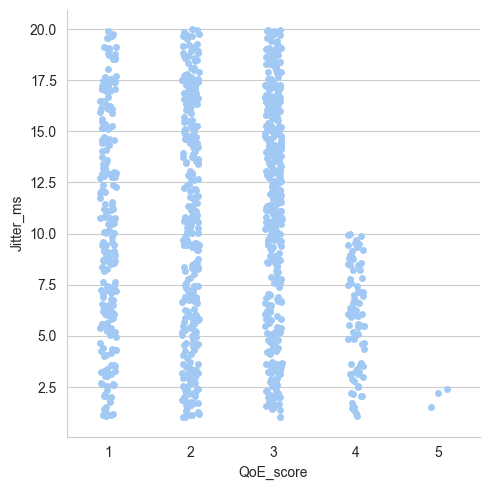

In [84]:
sns.catplot(data= data, x='QoE_score', y = 'Jitter_ms')

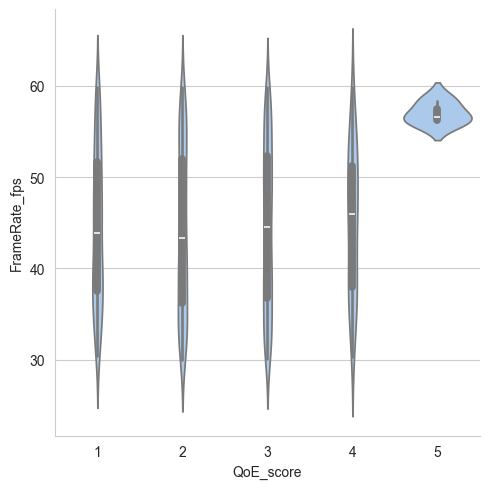

In [85]:
sns.catplot(data= data,kind='violin', x='QoE_score', y = 'FrameRate_fps')

<Axes: xlabel='QoE_score', ylabel='Bandwidth_MBps'>

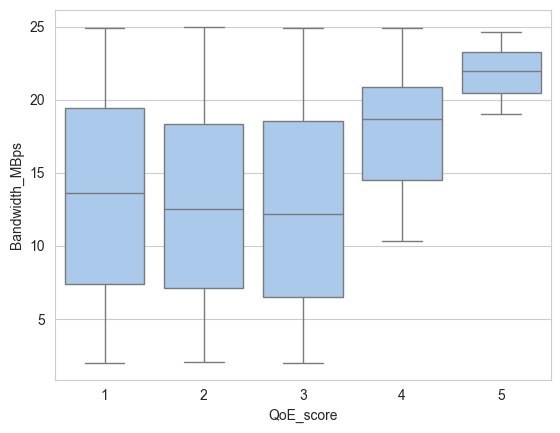

In [86]:
sns.boxplot(data=data, x='QoE_score', y= 'Bandwidth_MBps')

<Axes: xlabel='QoE_score', ylabel='CPU_usage'>

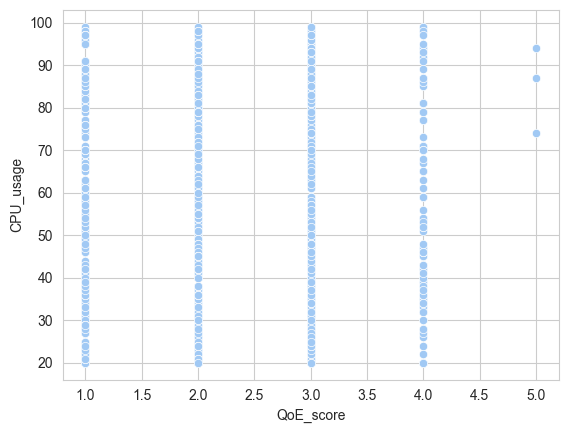

In [87]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'CPU_usage')


<Axes: xlabel='QoE_score', ylabel='GPU_usage'>

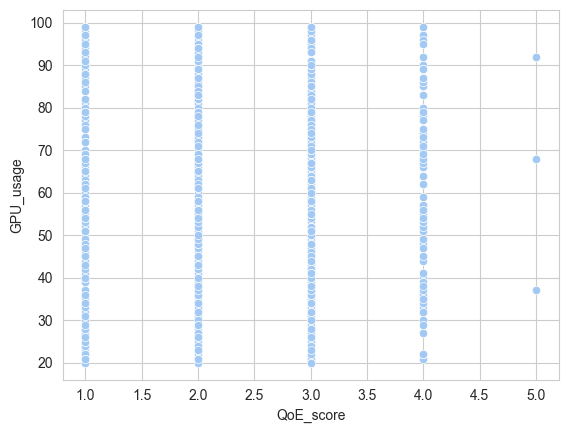

In [88]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'GPU_usage')


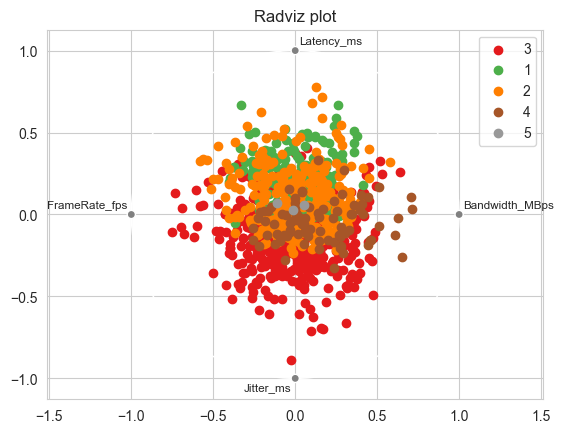

In [89]:
from pandas.plotting import radviz 

cols = ['Bandwidth_MBps', 'Latency_ms', 'FrameRate_fps', 'Jitter_ms', 'QoE_score']
radviz(data[cols], class_column='QoE_score', colormap='Set1')
plt.title('Radviz plot')
plt.show()


## Corrélation des données 

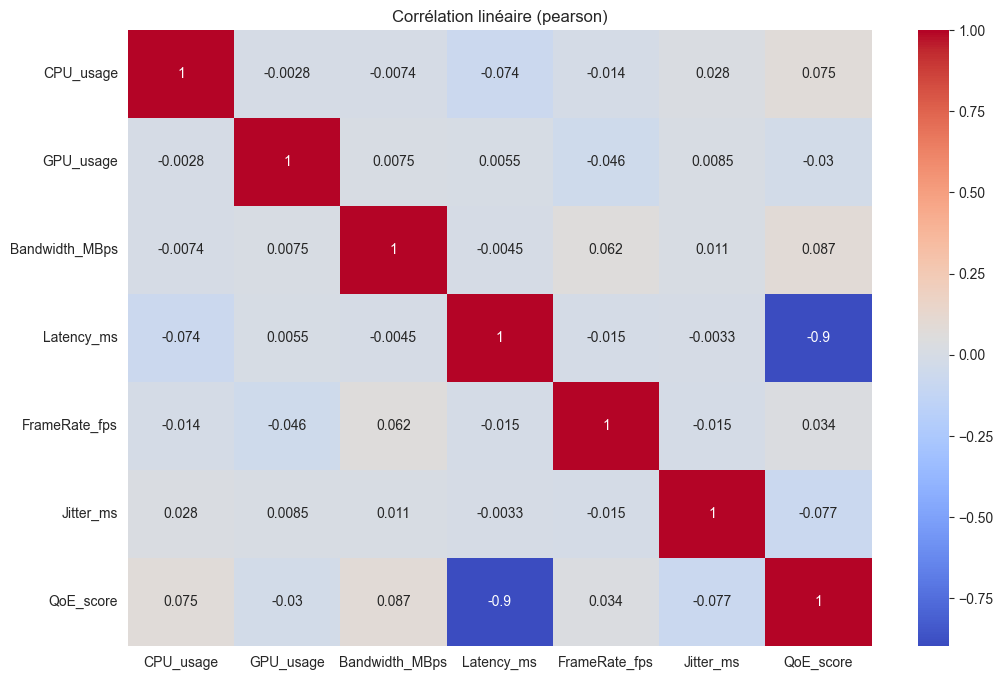

In [90]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Corrélation linéaire (pearson)')
plt.show()

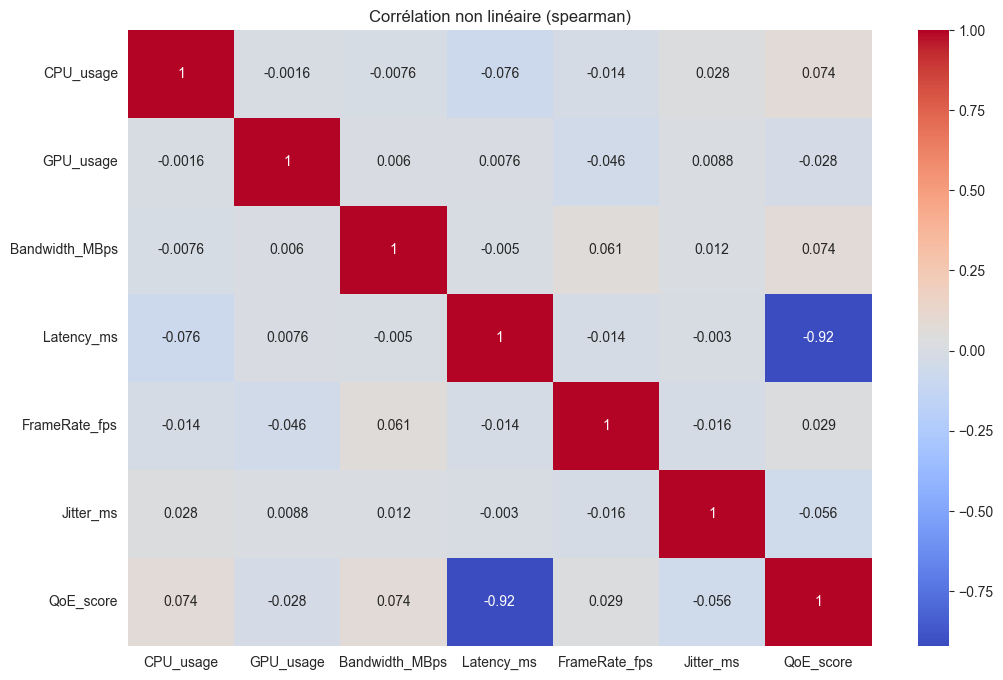

In [91]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Corrélation non linéaire (spearman)')
plt.show()

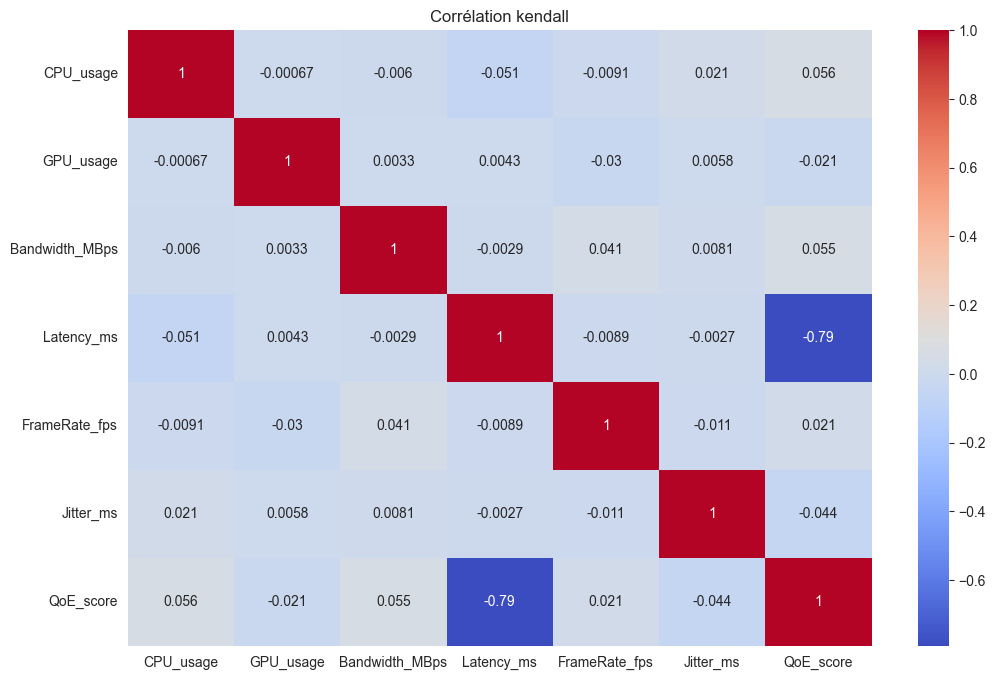

In [92]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(method='kendall'), annot=True, cmap='coolwarm')
plt.title('Corrélation kendall')
plt.show()

# Models for classification task 

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Modèles
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

Besoin de supprimer la classe note QoE = 5 car extrêmement minoritaire que le SMOTE ne fonctionne pas 

In [94]:
# 1. Suppression de la classe 5
data_classif = data[data['QoE_score'] != 5].copy()

# 2. Séparation features / cible
X = data_classif.drop('QoE_score', axis=1)
y = data_classif['QoE_score']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Equilibrage des classes : oversampling 

In [97]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [98]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [99]:
models = {
    'SVC': SVC(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'NearestCentroid': NearestCentroid(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=1000),
    "RFClassifier": RandomForestClassifier(random_state=42)
}

In [100]:
# 7. Entraînement + Évaluation
for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

--- SVC ---
[[63  4  0  0]
 [ 9 83  2  0]
 [ 0  6 98 10]
 [ 0  0  4 21]]
              precision    recall  f1-score   support

           1       0.88      0.94      0.91        67
           2       0.89      0.88      0.89        94
           3       0.94      0.86      0.90       114
           4       0.68      0.84      0.75        25

    accuracy                           0.88       300
   macro avg       0.85      0.88      0.86       300
weighted avg       0.89      0.88      0.88       300

--- SGDClassifier ---
[[67  0  0  0]
 [ 4 70 20  0]
 [ 0 30 64 20]
 [ 0  4  1 20]]
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        67
           2       0.67      0.74      0.71        94
           3       0.75      0.56      0.64       114
           4       0.50      0.80      0.62        25

    accuracy                           0.74       300
   macro avg       0.72      0.78      0.73       300
weighted avg       0.75      

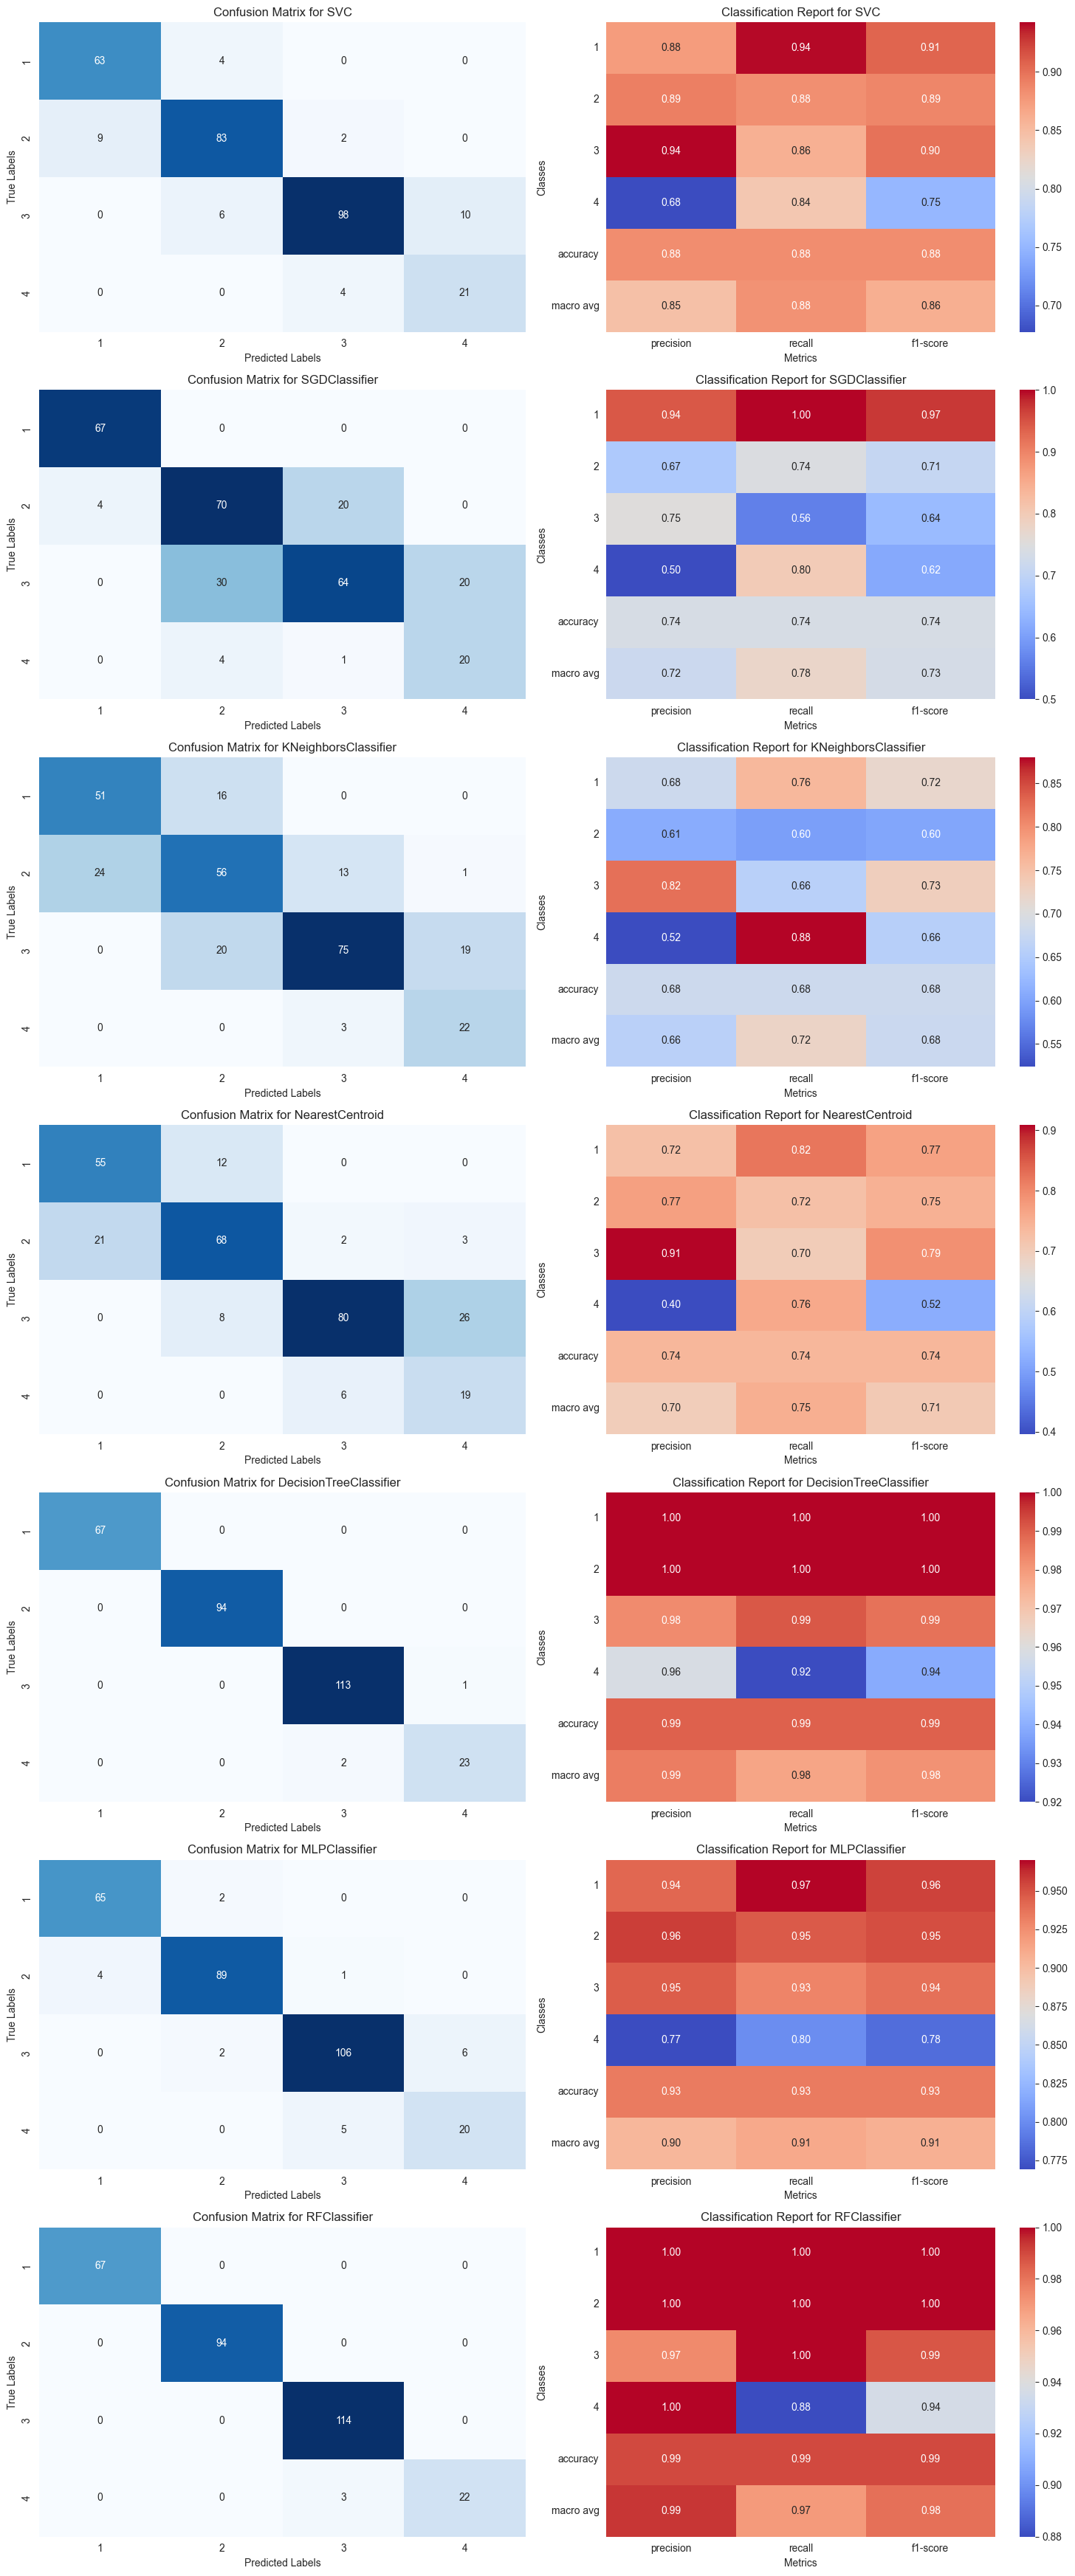

In [101]:
# Classes spécifiques de 1 à 4
class_labels = ['1', '2', '3', '4']

# Préparer un graphique de confusion et un tableau pour chaque modèle
fig, axes = plt.subplots(len(models), 2, figsize=(15, len(models) * 5))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i, 0], xticklabels=class_labels, yticklabels=class_labels)
    axes[i, 0].set_title(f'Confusion Matrix for {name}')
    axes[i, 0].set_xlabel('Predicted Labels')
    axes[i, 0].set_ylabel('True Labels')
    
    # Rapport de classification
    report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt='.2f', cmap='coolwarm', cbar=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Classification Report for {name}')
    axes[i, 1].set_xlabel('Metrics')
    axes[i, 1].set_ylabel('Classes')

# Ajuster la mise en page pour éviter les chevauchements
plt.tight_layout()
plt.show()

# Evaluation avancée : ROC, Cross-validation, confusion 

--- SVC ---
Cross-validation accuracy: 0.95 ± 0.02


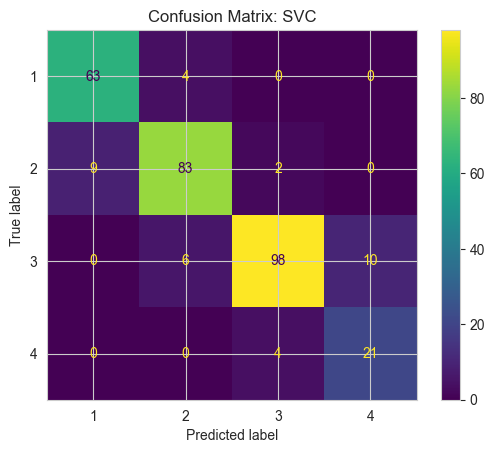

--- SGDClassifier ---
Cross-validation accuracy: 0.81 ± 0.04


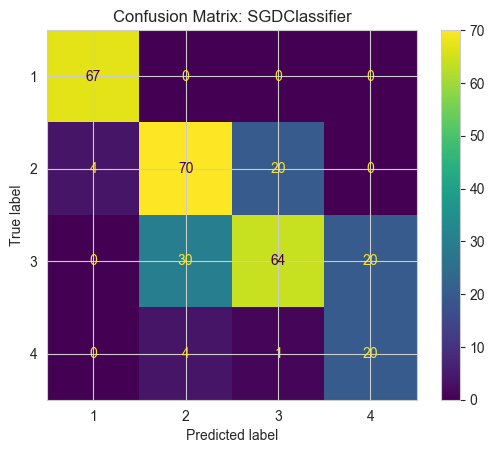

--- KNeighborsClassifier ---
Cross-validation accuracy: 0.83 ± 0.04


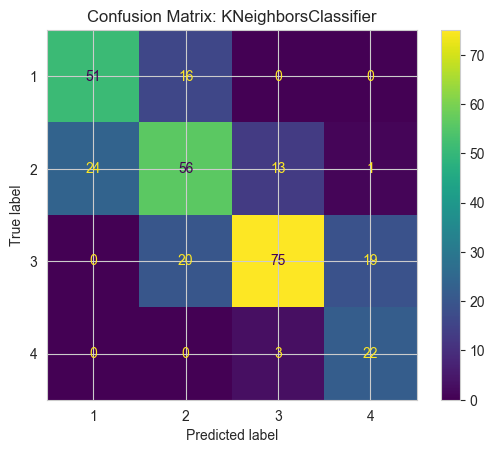

--- NearestCentroid ---
Cross-validation accuracy: 0.82 ± 0.02


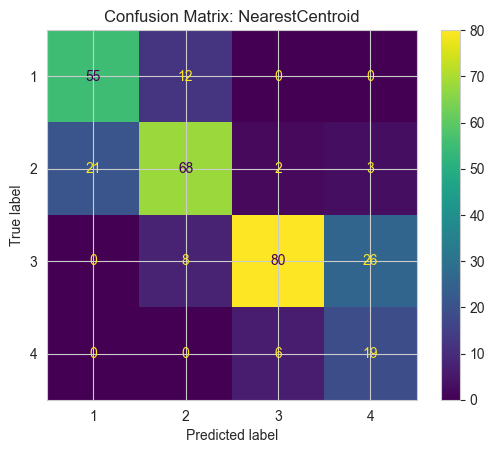

--- DecisionTreeClassifier ---
Cross-validation accuracy: 0.99 ± 0.01


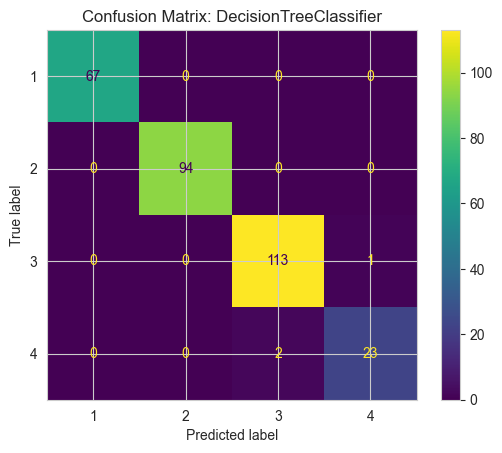

--- MLPClassifier ---
Cross-validation accuracy: 0.97 ± 0.01


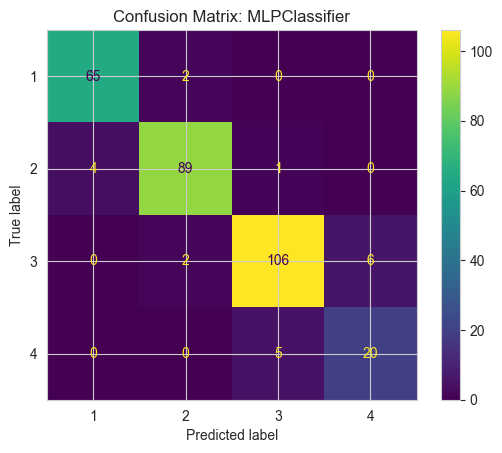

--- RFClassifier ---
Cross-validation accuracy: 0.99 ± 0.01


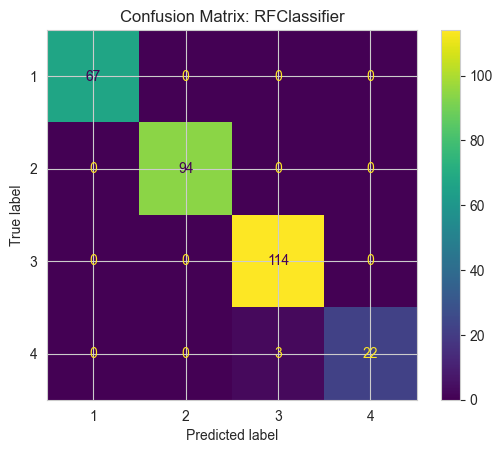

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay


for name, model in models.items():
    print(f"--- {name} ---")
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
    print(f"Cross-validation accuracy: {scores.mean():.2f} ± {scores.std():.2f}")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# Grid search

In [103]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
gs_svc = GridSearchCV(SVC(probability=True), param_grid, cv=5)
gs_svc.fit(X_train_resampled, y_train_resampled)
print("Best SVC params:", gs_svc.best_params_)

Best SVC params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


# Interprétation 

In [104]:
from sklearn.inspection import permutation_importance

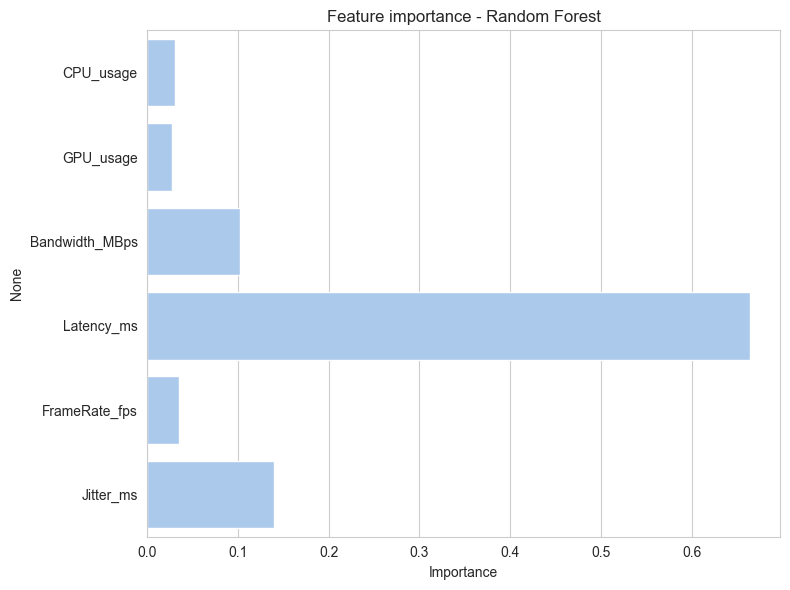

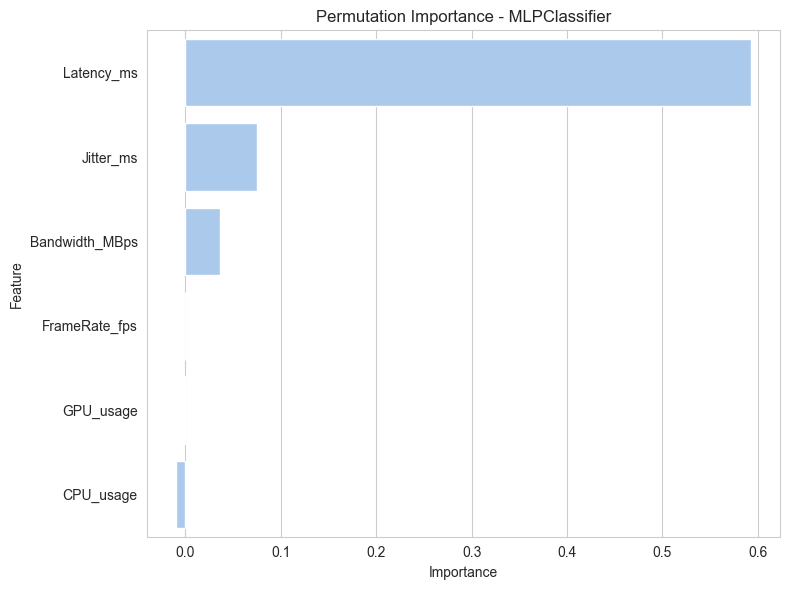

In [105]:
# Exemple avec Random Forest
rf = models['RFClassifier']
rf.fit(X_train_resampled, y_train_resampled)
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature importance - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Exemple avec permutation importance pour MLP
mlp = models['MLPClassifier']
mlp.fit(X_train_resampled, y_train_resampled)
perm = permutation_importance(mlp, X_test_scaled, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title("Permutation Importance - MLPClassifier")
plt.tight_layout()
plt.show()

## SHAP

In [106]:
import shap

Using 697 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [04:22<00:00,  1.14it/s]


Analyse SHAP pour SVC:


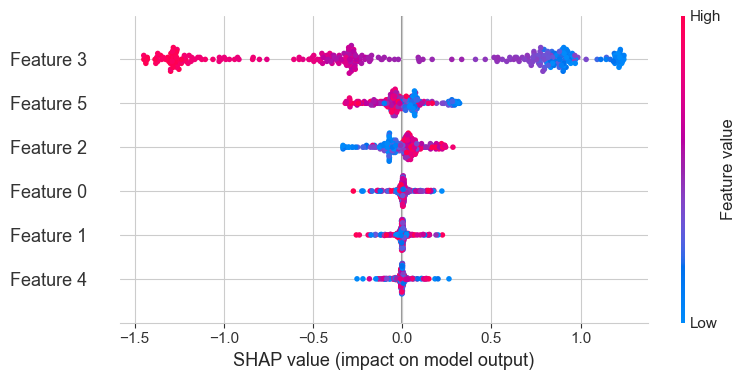

Using 697 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:01<00:00, 260.96it/s]


Analyse SHAP pour SGDClassifier:


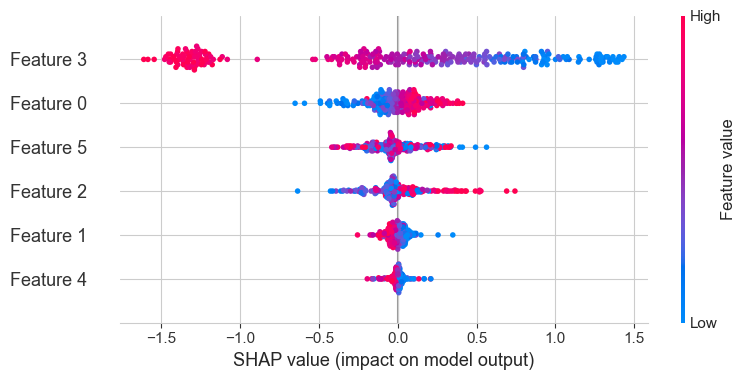

Using 697 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [04:12<00:00,  1.19it/s]

Analyse SHAP pour KNeighborsClassifier:


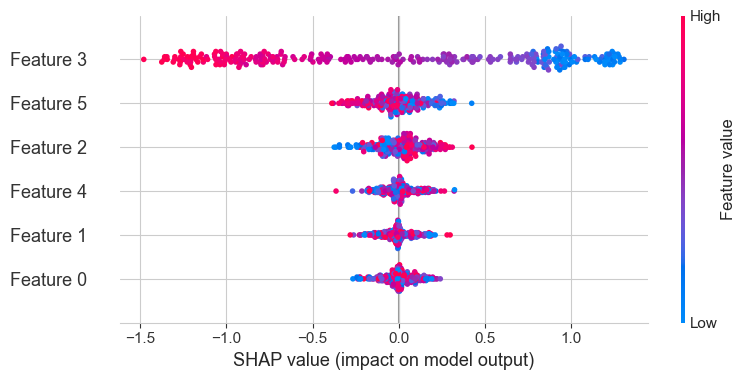

Using 697 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:01<00:00, 293.00it/s]


Analyse SHAP pour NearestCentroid:


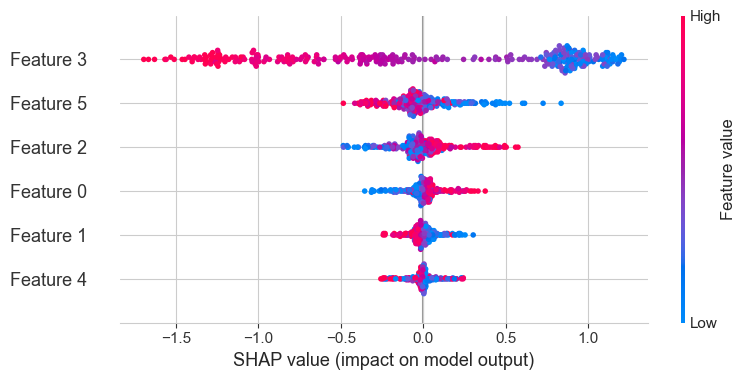

Analyse SHAP pour DecisionTreeClassifier:


<Figure size 640x480 with 0 Axes>

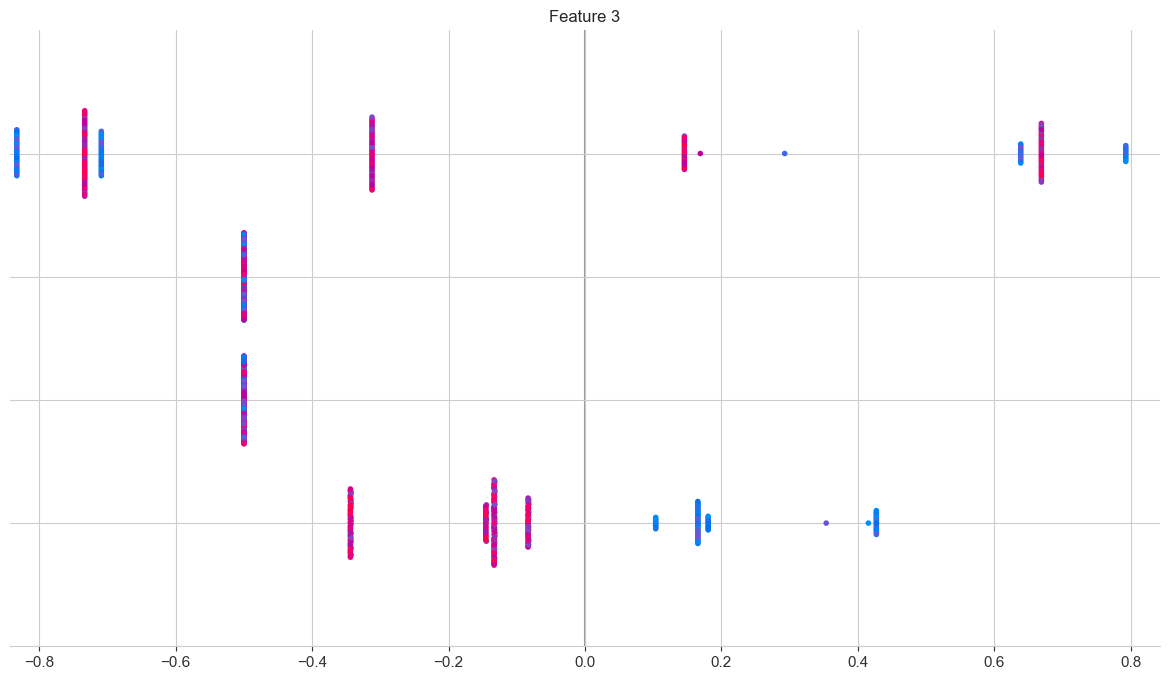

Using 697 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [00:07<00:00, 42.57it/s]


Analyse SHAP pour MLPClassifier:


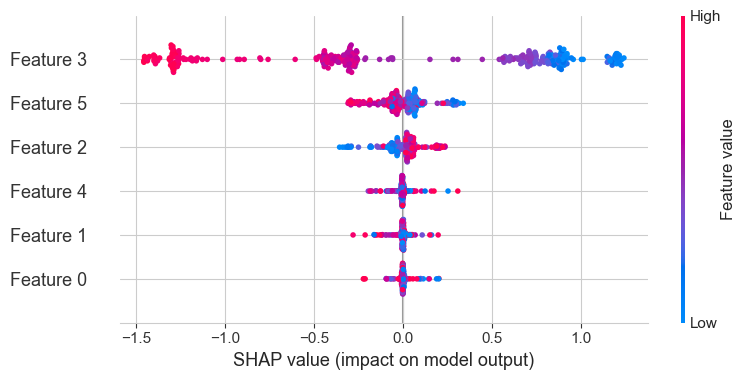

Analyse SHAP pour RFClassifier:


<Figure size 640x480 with 0 Axes>

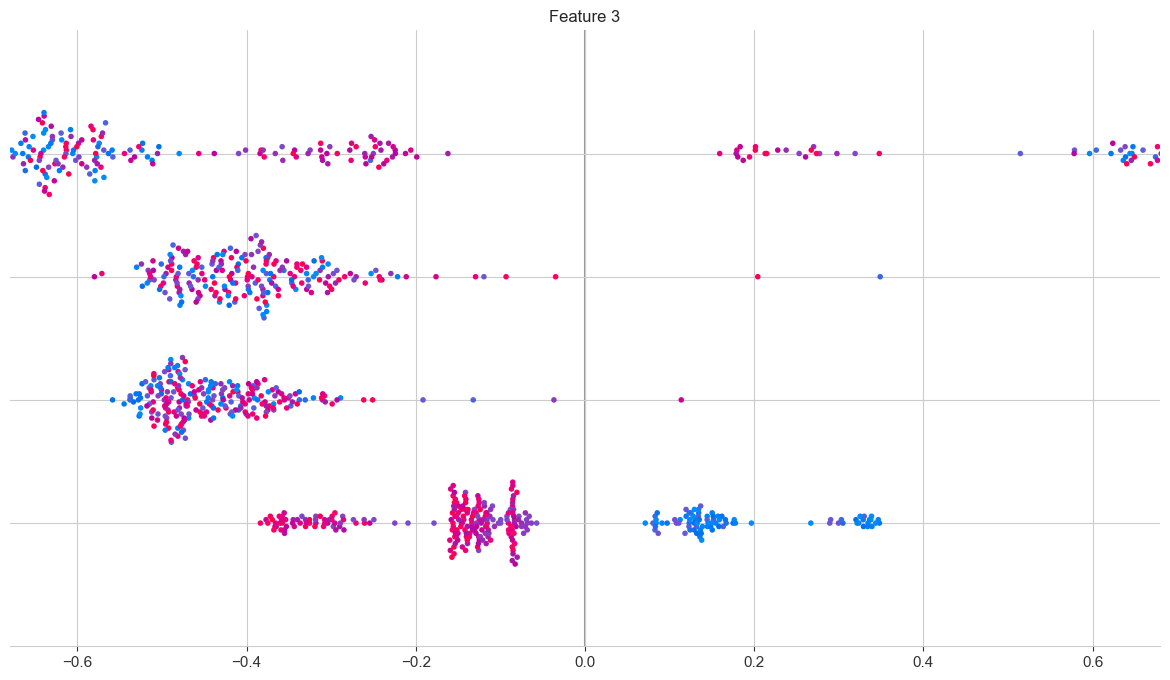

In [107]:
for model_name, model in models.items():

    
    # Sélection de l'explainer en fonction du modèle
    if model_name in ['DecisionTreeClassifier', 'RFClassifier']:  # Pour les arbres de décision et forêts
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict, X_train_scaled)
    
    # Calcul des valeurs SHAP
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Visualisation de l'impact des caractéristiques sur les prédictions du modèle
    print(f"Analyse SHAP pour {model_name}:")
    shap.summary_plot(shap_values, X_test_scaled)


# 🧲  Exploration non supervisée (t-SNE + clustering)

/Users/zahimchared/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


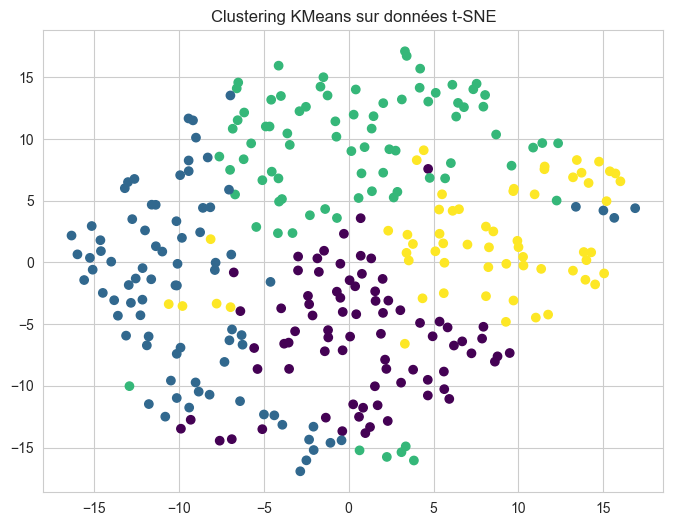

In [108]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

X_vis = TSNE(n_components=2, random_state=42).fit_transform(X_test_scaled)
kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(X_test_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_kmeans, cmap='viridis')
plt.title("Clustering KMeans sur données t-SNE")
plt.show()